In [1]:
'''
This code use machine learning metods to simulate the reduced dynamics in quantum many body systems, we use QuTip
simulation for data collection. In this case, in this case, we try to see to what extent neural network LSTM can capture
non-Markovian open quantum dynamics
'''

import numpy as np
from qutip import *
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#Physical system parameters
N=3  #Network size
T=100         #Temperature
gamma = 0.5   #Decoherence rate

#Spin oparators
# - Definition of Pauli operators

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#Defining the Ising Hamiltonian of a two-dimensional spin system with periodic bundary condition
def H2D_CBC(omega,omega_, delta, V, V_):
    #System hamiltonian
    H_S = omega_*sx_list[1][1] - delta*n_list[1][1] + V_*(n_list[1][1])*(n_list[0][1]+n_list[1][0]+n_list[1][2]+n_list[2][1])
    #Bath hamiltonian
    H_B = 0
    for i in range(N):
        for j in range(N):
            if sx_list[i][j] != sx_list[1][1] and n_list[i][j] != n_list[1][1]:
                H_B += omega*sx_list[i][j] - delta*n_list[i][j] +V*n_list[i][j]*(n_list[(i+1)%N][j] + n_list[i][(j+1)%N])
    H = H_S + H_B
    return(H)


##########################################################################################################
#Bath state
def H_bain(omega, delta, V):
    id_B= tensor([qeye(2)]*(N*N-2))
    sx_B = [[tensor(id_B, sigmax())]*N]*N
    sy_B = [[tensor(id_B, sigmay())]*N]*N
    sz_B = [[tensor(id_B, sigmaz())]*N]*N
    n_B = [[tensor(id_B, 0.5*(1 + sigmaz()))]*N]*N
    H_B = 0
    for i in range(N):
        for j in range(N):
            if i==j == 1:
                H_B += 0
            else:
                H_B += omega*sx_B[i][j] - delta*n_B[i][j] +V*n_B[i][j]*(n_B[(i+1)%N][j] + n_B[i][(j+1)%N])
    return(H_B)


H_B = H_bain(omega=1, delta=0.2, V=4)

a= np.random.uniform(0,0.7)
hro0_S = Qobj([[0.47086478,0],[0,0.52913522]])
print('Etat initial:',hro0_S)

###########################################################################################################

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0
############################################################################################################
# Dynamical simulation with Quantum Tolbox in Python (QuTip) and visualisation
############################################################################################################
H = H2D_CBC(omega = 1, omega_=1, delta=0, V=4, V_=2)

#Importing libraries for machine learning
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []

for beta in beta_list:
    hro_B =(-beta*H_B).expm()
    rho0 = tensor(hro0_S, hro_B)
    
############################################################################################################
#DATA COLLECTION WITH QuTip SIMULATION
############################################################################################################

    tlist = np.linspace(0.0, 1.0, 100)
    resultx = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    X0 = resultx.expect[0]
    X1 = resultx.expect[1]
    X2 = resultx.expect[2]

    tlist = np.linspace(0.0+0.2, 1.0, 100)
    resulty = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    ####
    X = np.transpose([np.ones(100), X0, X1, X2])  ##Input data set
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Output data set

    #Divide all data into training set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, train_size = 0.6, random_state = None, shuffle=False, stratify = None)
    
    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    #print('mean square error:', mse)
    print('mean absolute error:', mae)

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47086478 0.        ]
 [0.         0.52913522]]


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4644291899257063
mean absolute error: 0.6239466409456033
mean absolute error: 0.5318709966914874
mean absolute error: 0.641417562456346
mean absolute error: 0.8173557501029715
mean absolute error: 0.8469596901297558
mean absolute error: 1.7822975586052123
mean absolute error: 0.9379859175163053
mean absolute error: 0.8510693166271472
mean absolute error: 1.1711971521026365
mean absolute error: 1.1772302546524038


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.207770788450551
mean absolute error: 1.5603957810442024
mean absolute error: 1.7214443948511406
mean absolute error: 1.5594606772181332


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [2]:
y1 = mae_list

In [3]:
'''
This code use machine learning metods to simulate the reduced dynamics in quantum many body systems, we use QuTip
simulation for data collection. In this case, in this case, we try to see to what extent neural network LSTM can capture
non-Markovian open quantum dynamics
'''

import numpy as np
from qutip import *
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#Physical system parameters
N=3  #Network size
T=100         #Temperature
gamma = 0.5   #Decoherence rate

#Spin oparators
# - Definition of Pauli operators

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#Defining the Ising Hamiltonian of a two-dimensional spin system with periodic bundary condition
def H2D_CBC(omega,omega_, delta, V, V_):
    #System hamiltonian
    H_S = omega_*sx_list[1][1] - delta*n_list[1][1] + V_*(n_list[1][1])*(n_list[0][1]+n_list[1][0]+n_list[1][2]+n_list[2][1])
    #Bath hamiltonian
    H_B = 0
    for i in range(N):
        for j in range(N):
            if sx_list[i][j] != sx_list[1][1] and n_list[i][j] != n_list[1][1]:
                H_B += omega*sx_list[i][j] - delta*n_list[i][j] +V*n_list[i][j]*(n_list[(i+1)%N][j] + n_list[i][(j+1)%N])
    H = H_S + H_B
    return(H)


##########################################################################################################
#Bath state
def H_bain(omega, delta, V):
    id_B= tensor([qeye(2)]*(N*N-2))
    sx_B = [[tensor(id_B, sigmax())]*N]*N
    sy_B = [[tensor(id_B, sigmay())]*N]*N
    sz_B = [[tensor(id_B, sigmaz())]*N]*N
    n_B = [[tensor(id_B, 0.5*(1 + sigmaz()))]*N]*N
    H_B = 0
    for i in range(N):
        for j in range(N):
            if i==j == 1:
                H_B += 0
            else:
                H_B += omega*sx_B[i][j] - delta*n_B[i][j] +V*n_B[i][j]*(n_B[(i+1)%N][j] + n_B[i][(j+1)%N])
    return(H_B)


H_B = H_bain(omega=1, delta=0.2, V=4)

a= np.random.uniform(0,0.7)
hro0_S = Qobj([[0.47086478,0],[0,0.52913522]])
print('Etat initial:',hro0_S)

###########################################################################################################

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0
############################################################################################################
# Dynamical simulation with Quantum Tolbox in Python (QuTip) and visualisation
############################################################################################################
H = H2D_CBC(omega = 1, omega_=1, delta=0.5, V=4, V_=0.2)

#Importing libraries for machine learning
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []

for beta in beta_list:
    hro_B =(-beta*H_B).expm()
    rho0 = tensor(hro0_S, hro_B)
    
############################################################################################################
#DATA COLLECTION WITH QuTip SIMULATION
############################################################################################################

    tlist = np.linspace(0.0, 1.0, 100)
    resultx = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    X0 = resultx.expect[0]
    X1 = resultx.expect[1]
    X2 = resultx.expect[2]

    tlist = np.linspace(0.0+0.2, 1.0, 100)
    resulty = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    ####
    X = np.transpose([np.ones(100), X0, X1, X2])  ##Input data set
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Output data set

    #Divide all data into training set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, train_size = 0.6, random_state = None, shuffle=False, stratify = None)
    
    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    #print('mean square error:', mse)
    print('mean absolute error:', mae)

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47086478 0.        ]
 [0.         0.52913522]]


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.6150440556479067
mean absolute error: 0.364410807353271
mean absolute error: 0.3863949759736004
mean absolute error: 0.41900496576070817
mean absolute error: 0.5656046309928202
mean absolute error: 0.47693223245988386
mean absolute error: 0.6191071251613477
mean absolute error: 0.6394520201060541
mean absolute error: 0.7334016910407481
mean absolute error: 0.85596213693343
mean absolute error: 0.8007141445581052
mean absolute error: 1.0245224149151992
mean absolute error: 1.1967289148073075
mean absolute error: 1.217830450963458
mean absolute error: 1.1722535377571472


In [4]:
y2 = mse_list

In [5]:
'''
This code use machine learning metods to simulate the reduced dynamics in quantum many body systems, we use QuTip
simulation for data collection. In this case, in this case, we try to see to what extent neural network LSTM can capture
non-Markovian open quantum dynamics
'''

import numpy as np
from qutip import *
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#Physical system parameters
N=3  #Network size
T=100         #Temperature
gamma = 0.5   #Decoherence rate

#Spin oparators
# - Definition of Pauli operators

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#Defining the Ising Hamiltonian of a two-dimensional spin system with periodic bundary condition
def H2D_CBC(omega,omega_, delta, V, V_):
    #System hamiltonian
    H_S = omega_*sx_list[1][1] - delta*n_list[1][1] + V_*(n_list[1][1])*(n_list[0][1]+n_list[1][0]+n_list[1][2]+n_list[2][1])
    #Bath hamiltonian
    H_B = 0
    for i in range(N):
        for j in range(N):
            if sx_list[i][j] != sx_list[1][1] and n_list[i][j] != n_list[1][1]:
                H_B += omega*sx_list[i][j] - delta*n_list[i][j] +V*n_list[i][j]*(n_list[(i+1)%N][j] + n_list[i][(j+1)%N])
    H = H_S + H_B
    return(H)


##########################################################################################################
#Bath state
def H_bain(omega, delta, V):
    id_B= tensor([qeye(2)]*(N*N-2))
    sx_B = [[tensor(id_B, sigmax())]*N]*N
    sy_B = [[tensor(id_B, sigmay())]*N]*N
    sz_B = [[tensor(id_B, sigmaz())]*N]*N
    n_B = [[tensor(id_B, 0.5*(1 + sigmaz()))]*N]*N
    H_B = 0
    for i in range(N):
        for j in range(N):
            if i==j == 1:
                H_B += 0
            else:
                H_B += omega*sx_B[i][j] - delta*n_B[i][j] +V*n_B[i][j]*(n_B[(i+1)%N][j] + n_B[i][(j+1)%N])
    return(H_B)


H_B = H_bain(omega=1, delta=0.2, V=4)

a= np.random.uniform(0,0.7)
hro0_S = Qobj([[0.47086478,0],[0,0.52913522]])
print('Etat initial:',hro0_S)

###########################################################################################################

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0
############################################################################################################
# Dynamical simulation with Quantum Tolbox in Python (QuTip) and visualisation
############################################################################################################
H = H2D_CBC(omega = 1, omega_=1, delta=0.5, V=4, V_=8)

#Importing libraries for machine learning
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


beta_list = np.arange(0, 1.5, 0.1)
mse_list = []
mae_list = []

for beta in beta_list:
    hro_B =(-beta*H_B).expm()
    rho0 = tensor(hro0_S, hro_B)
    
############################################################################################################
#DATA COLLECTION WITH QuTip SIMULATION
############################################################################################################

    tlist = np.linspace(0.0, 1.0, 100)
    resultx = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    X0 = resultx.expect[0]
    X1 = resultx.expect[1]
    X2 = resultx.expect[2]

    tlist = np.linspace(0.0+0.2, 1.0, 100)
    resulty = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
    Y0 = resulty.expect[0]
    Y1 = resulty.expect[1]
    Y2 = resulty.expect[2]

    ####
    X = np.transpose([np.ones(100), X0, X1, X2])  ##Input data set
    Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Output data set

    #Divide all data into training set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, train_size = 0.6, random_state = None, shuffle=False, stratify = None)
    
    # Architechture neuronale du perceptron multicouche
    model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

    #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
    model.fit(X_train, Y_train)

    #Evaluation de la performence du modele avec l'ensemble des donnees de test
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mse_list.append(mse)
    mae_list.append(mae)
    #print('mean square error:', mse)
    print('mean absolute error:', mae)

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47086478 0.        ]
 [0.         0.52913522]]


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.22831777389339156
mean absolute error: 0.2563708225192009
mean absolute error: 0.4273903090804043
mean absolute error: 0.5219456803631536
mean absolute error: 0.4277383843628576


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.389507097091213
mean absolute error: 0.624307910629837
mean absolute error: 0.6627095234153493
mean absolute error: 0.43140180864625804
mean absolute error: 0.9297104604676636
mean absolute error: 0.9851269615166862
mean absolute error: 0.7553686997522073
mean absolute error: 1.2161704910314581


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8554701591602507
mean absolute error: 1.2051452450112503


In [6]:
y3 = mae_list

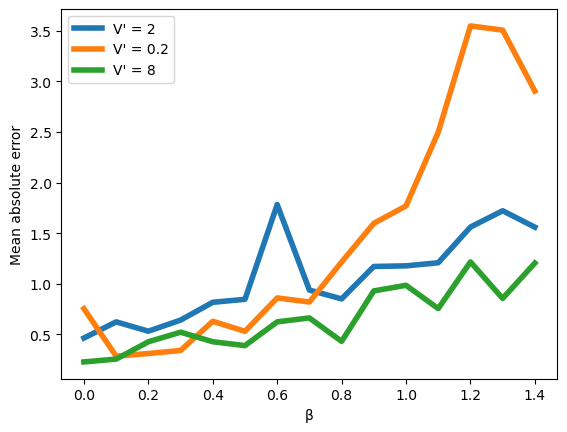

In [8]:
import matplotlib.pyplot as plt

x = beta_list

fig, ax = plt.subplots()
ax.plot(x, y1, label= "V' = 2" , linewidth=4)
ax.plot(x, y2, label="V' = 0.2", linewidth=4)
ax.plot(x, y3, label="V' = 8", linewidth=4)
ax.set_xlabel('β')
ax.set_ylabel('Mean absolute error')
#ax.grid(True)
plt.legend()
plt.show()

In [3]:
'''
This code use machine learning metods to simulate the reduced dynamics in quantum many body systems, we use QuTip
simulation for data collection. In this case, in this case, we try to see to what extent neural network LSTM can capture
non-Markovian open quantum dynamics
'''

import numpy as np
from qutip import *
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#Physical system parameters
N=3  #Network size
T=100         #Temperature
gamma = 0.5   #Decoherence rate

#Spin oparators
# - Definition of Pauli operators

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#Defining the Ising Hamiltonian of a two-dimensional spin system with periodic bundary condition
def H2D_CBC(omega,omega_, delta, V, V_):
    #System hamiltonian
    H_S = omega_*sx_list[1][1] - delta*n_list[1][1] + V_*(n_list[1][1])*(n_list[0][1]+n_list[1][0]+n_list[1][2]+n_list[2][1])
    #Bath hamiltonian
    H_B = 0
    for i in range(N):
        for j in range(N):
            if sx_list[i][j] != sx_list[1][1] and n_list[i][j] != n_list[1][1]:
                H_B += omega*sx_list[i][j] - delta*n_list[i][j] +V*n_list[i][j]*(n_list[(i+1)%N][j] + n_list[i][(j+1)%N])
    H = H_S + H_B
    return(H)


##########################################################################################################
#Bath state
def H_bain(omega, delta, V):
    id_B= tensor([qeye(2)]*(N*N-2))
    sx_B = [[tensor(id_B, sigmax())]*N]*N
    sy_B = [[tensor(id_B, sigmay())]*N]*N
    sz_B = [[tensor(id_B, sigmaz())]*N]*N
    n_B = [[tensor(id_B, 0.5*(1 + sigmaz()))]*N]*N
    H_B = 0
    for i in range(N):
        for j in range(N):
            if i==j == 1:
                H_B += 0
            else:
                H_B += omega*sx_B[i][j] - delta*n_B[i][j] +V*n_B[i][j]*(n_B[(i+1)%N][j] + n_B[i][(j+1)%N])
    return(H_B)

a= np.random.uniform(0,0.7)
hro0_S = Qobj([[0.47086478,0],[0,0.52913522]])
print('Etat initial:',hro0_S)

###########################################################################################################

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0
############################################################################################################
# Dynamical simulation with Quantum Tolbox in Python (QuTip) and visualisation
############################################################################################################

#Importing libraries for machine learning
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


beta_list = np.arange(0, 2, 0.1)
V_list = np.arange(0, 8, 0.5)
mse_list = []
mae_list = []
omega = 1
omega_ = 1
delta = 0.5
V = 4
for beta in beta_list:
    for V_ in V_list:
        H = H2D_CBC(omega, omega_, delta, V, V)
        H_B = H_bain(omega, delta, V)
        hro_B =(-beta*H_B).expm()
        rho0 = tensor(hro0_S, hro_B)
    
############################################################################################################
#DATA COLLECTION WITH QuTip SIMULATION
############################################################################################################

        tlist = np.linspace(0.0, 1.0, 100)
        resultx = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
        X0 = resultx.expect[0]
        X1 = resultx.expect[1]
        X2 = resultx.expect[2]

        tlist = np.linspace(0.0+0.2, 1.0, 100)
        resulty = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        ####
        X = np.transpose([np.ones(100), X0, X1, X2])  ##Input data set
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Output data set

        #Divide all data into training set and test set
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, train_size = 0.6, random_state = None, shuffle=False, stratify = None)
    
        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
        #print('mean square error:', mse)
        print('mean absolute error:', mae)

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47086478 0.        ]
 [0.         0.52913522]]


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.41229277849519647
mean absolute error: 0.8633007775317648
mean absolute error: 0.7202418511311781
mean absolute error: 0.9306793009840757


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4270666628478073


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.4112508127595066


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3872206923707957


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3683195822920578
mean absolute error: 0.9024551409000461


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3877717993960009


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.41240268765668947
mean absolute error: 0.7787798883164037


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.38807924843543146
mean absolute error: 0.6584785724960178
mean absolute error: 0.7219936338863779


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.3897654341468973
mean absolute error: 0.41036914240190825
mean absolute error: 0.4024895015171156
mean absolute error: 0.40669640800971324
mean absolute error: 0.4123861608945939
mean absolute error: 0.4152824703204836
mean absolute error: 0.41489234109867534
mean absolute error: 0.40862674723451753
mean absolute error: 0.39292160968220996
mean absolute error: 0.4129884834616147
mean absolute error: 0.7435658207879359
mean absolute error: 0.40450718365716876
mean absolute error: 0.40764885570397075
mean absolute error: 0.4103109984579314
mean absolute error: 0.40816795407442086
mean absolute error: 0.39196220731348497
mean absolute error: 0.39606672500625417
mean absolute error: 0.44785447756534696
mean absolute error: 0.44456336251482054
mean absolute error: 0.8693906475848245
mean absolute error: 0.968035672083406
mean absolute error: 0.43453629361277163
mean absolute error: 0.443671123874178
mean absolute error: 0.44364982117868784
mean absolute error: 0.44254

C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.5564933515934374
mean absolute error: 0.5563614197014126
mean absolute error: 1.0927775035969285
mean absolute error: 0.5888041727487394
mean absolute error: 0.5953145766150861
mean absolute error: 0.6241653714817141
mean absolute error: 0.6277586723999093
mean absolute error: 0.6051308928884832
mean absolute error: 0.6149188074964297
mean absolute error: 0.6359948443989061
mean absolute error: 0.6181999409353733
mean absolute error: 0.6087415104230376
mean absolute error: 0.615739960659543
mean absolute error: 0.639416868654644
mean absolute error: 0.6205855816994972
mean absolute error: 1.1340191744859822
mean absolute error: 0.6174376583456005
mean absolute error: 0.5904626454096258
mean absolute error: 0.6341221008218905
mean absolute error: 0.6321966983134072
mean absolute error: 0.6898917234741775
mean absolute error: 0.6774001623690344
mean absolute error: 0.6851867711978916
mean absolute error: 0.6973803460063739
mean absolute error: 0.6928853085913
mean 

C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.8387763559169938
mean absolute error: 0.8740572316508136
mean absolute error: 0.8414724874747329
mean absolute error: 0.8323585673732323
mean absolute error: 0.8723152081910839
mean absolute error: 0.8518785671409602
mean absolute error: 0.8422654111561332
mean absolute error: 0.8500489984477543
mean absolute error: 0.8586392308725104
mean absolute error: 0.82817431815758
mean absolute error: 1.5864313961985421
mean absolute error: 0.9303070069545021
mean absolute error: 0.9449647667939924


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9006599719009261
mean absolute error: 0.9877180898423777
mean absolute error: 0.9488016409961235
mean absolute error: 0.9271647628100131
mean absolute error: 0.9698127639728864
mean absolute error: 0.9432793696439218
mean absolute error: 0.9403811899961579


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9151114431149622
mean absolute error: 0.9593595988712611


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.959477259503129
mean absolute error: 0.9918639858171228
mean absolute error: 0.981817119885723


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 0.9688646627401738
mean absolute error: 1.9258403651288158
mean absolute error: 1.7644098940240789
mean absolute error: 1.013186316691538
mean absolute error: 2.195609892004069
mean absolute error: 2.2403870809416224
mean absolute error: 1.8156862656104316
mean absolute error: 1.029851916540164
mean absolute error: 1.0373779207318627
mean absolute error: 2.4936533501101774
mean absolute error: 1.0584062264963783
mean absolute error: 1.063582967449365
mean absolute error: 1.8118986124165763
mean absolute error: 1.0235270129636076
mean absolute error: 1.7181338969768396
mean absolute error: 1.6561988548463622
mean absolute error: 1.0490573164589376
mean absolute error: 1.0733724094984232


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1814066881639957
mean absolute error: 2.437779988793553
mean absolute error: 2.2975168174984737
mean absolute error: 1.1532941420437022
mean absolute error: 1.1195493108725951
mean absolute error: 2.627521647354518


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1469733943031188
mean absolute error: 1.15987125188857
mean absolute error: 1.1878953090156128
mean absolute error: 2.0900491505532997
mean absolute error: 1.1703832684265014
mean absolute error: 2.0810687810098702


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1959736080629397


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.15527360657084


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1710110635866742


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.1309762401767003


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2699251074550992
mean absolute error: 2.9828551770249927


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3075029908628697


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3072012878808064


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2674799807789117
mean absolute error: 1.2823680188068796
mean absolute error: 1.3119621417561298
mean absolute error: 2.6142395413387653
mean absolute error: 1.3074895843665795
mean absolute error: 1.256439583407168
mean absolute error: 2.235890359220381
mean absolute error: 2.8918121762244846


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2609776644235196
mean absolute error: 1.2902438133979368


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2692922322682465


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.2483521055252493


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4257982389453996


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3999147308406585


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3917964099056868


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4281540829779875


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.3878695989822525


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4543656964427214


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.393444523047804


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4476969820685972


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4004689211869399


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.408872839490569
mean absolute error: 2.6812373742264413


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.396777153314531


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4172222016067264
mean absolute error: 2.4521817724906523


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4632598235087357


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.4095302893250494


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5971551888737199


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.593413036493798


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5872319410371198


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5999558441505102
mean absolute error: 3.1492215288790346


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.629096132109435


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6051316597689418


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5973349283890077
mean absolute error: 2.840313482103498


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.5730844642535966


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6236222758122425


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6157334191435873


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.610151556973329
mean absolute error: 2.82916972865217


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6051186120590033


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.6267931775092128
mean absolute error: 3.339119347737253


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7213203492472162


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7551150426996285


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7328292910773517


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.745360806640334


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7917855667255231
mean absolute error: 1.7962784891399493
mean absolute error: 2.621005090512542


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7330651428697736


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7160232338888544


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7353893762270918


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7402920266469288
mean absolute error: 3.45122170091068


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.746045738129173


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7679457110706511


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.7226172208996835
mean absolute error: 4.262179461932219
mean absolute error: 3.609396007184877


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.8955385541366452


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9305839098740456


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.8715767263382599
mean absolute error: 3.6498625683828845


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9461957359520032
mean absolute error: 3.492431614695271


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9683152492260239


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9421235981023772


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9310486855320734
mean absolute error: 3.3363956725478627


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9406413113559349


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.0214624198941222


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9517462639078969


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 1.9416648466491455


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.1326734189632695


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.0267392326315767


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.13418552177222
mean absolute error: 3.8760312061991966


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.162970112117909


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.173583419392314
mean absolute error: 3.7458931926092234


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.184941245367191


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.1758986281222867


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.09583216625774


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.1175888182545006
mean absolute error: 4.0410642168729805


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.260770444364895


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.093873311714534
mean absolute error: 3.355384038653583


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.121126662761667


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.385007428879346


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.3643180202251424


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.484432511191619


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.4016163269507516


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.415153179880334


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.3927394271881317


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.5504434192211596


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.333435455059808


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.449131089615707
mean absolute error: 4.626060341396775


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.360249192802384


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.4222101301751717


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.5214364085982974


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.422430043067868


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.401044583505656


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.3739792864233853


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.702839687740596
mean absolute error: 5.349922974731873


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.645704520105725


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.654379580293394


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.620696593944673
mean absolute error: 4.433170928502358
mean absolute error: 5.216801580566221


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.73666112559466


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.7298471015730996
mean absolute error: 5.1399518528525014


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.5897879616460937


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.626004955183539


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.6927430011467726


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean absolute error: 2.6820193159661163
mean absolute error: 4.266429994598146
mean absolute error: 2.6860107501181223


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


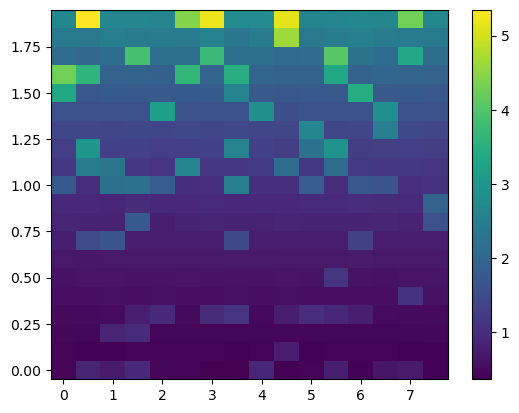

In [4]:
import matplotlib.pyplot as plt
import numpy as np

z = np.array(mae_list)
# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(V_list, beta_list)

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale
plt.title("Error_eval_2D_CBC")
plt.savefig('Error_eval_2D_CBC.png')

# Show the plot
plt.show()

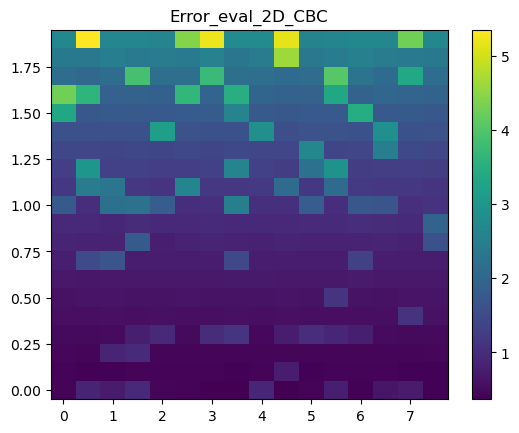

In [5]:
import matplotlib.pyplot as plt
import numpy as np

z = np.array(mae_list)
# Create a 2-D grid from the 1-D arrays
X, Y = np.meshgrid(V_list, beta_list)

# Define a function to plot
Z = z.reshape(Y.shape)

# Create a pseudocolor plot with a non-regular rectangular grid
plt.pcolormesh(X, Y, Z)
plt.colorbar() # Add a color bar to show the scale
plt.title("Error_eval_2D_CBC")
plt.savefig('Error_eval_2D_CBC.png')

# Show the plot
plt.show()

In [ ]:
'''
This code use machine learning metods to simulate the reduced dynamics in quantum many body systems, we use QuTip
simulation for data collection. In this case, in this case, we try to see to what extent neural network LSTM can capture
non-Markovian open quantum dynamics
'''

import numpy as np
from qutip import *
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#Physical system parameters
N=3  #Network size
T=100         #Temperature
gamma = 0.5   #Decoherence rate

#Spin oparators
# - Definition of Pauli operators

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#Defining the Ising Hamiltonian of a two-dimensional spin system with periodic bundary condition
def H2D_CBC(omega,omega_, delta, V, V_):
    #System hamiltonian
    H_S = omega_*sx_list[1][1] - delta*n_list[1][1] + V_*(n_list[1][1])*(n_list[0][1]+n_list[1][0]+n_list[1][2]+n_list[2][1])
    #Bath hamiltonian
    H_B = 0
    for i in range(N):
        for j in range(N):
            if sx_list[i][j] != sx_list[1][1] and n_list[i][j] != n_list[1][1]:
                H_B += omega*sx_list[i][j] - delta*n_list[i][j] +V*n_list[i][j]*(n_list[(i+1)%N][j] + n_list[i][(j+1)%N])
    H = H_S + H_B
    return(H)


##########################################################################################################
#Bath state
def H_bain(omega, delta, V):
    id_B= tensor([qeye(2)]*(N*N-2))
    sx_B = [[tensor(id_B, sigmax())]*N]*N
    sy_B = [[tensor(id_B, sigmay())]*N]*N
    sz_B = [[tensor(id_B, sigmaz())]*N]*N
    n_B = [[tensor(id_B, 0.5*(1 + sigmaz()))]*N]*N
    H_B = 0
    for i in range(N):
        for j in range(N):
            if i==j == 1:
                H_B += 0
            else:
                H_B += omega*sx_B[i][j] - delta*n_B[i][j] +V*n_B[i][j]*(n_B[(i+1)%N][j] + n_B[i][(j+1)%N])
    return(H_B)


hro0_S_list = [Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]]),
         Qobj([[1-np.random.uniform(0,0.7),0],[0,np.random.uniform(0,0.7)]])]
#print('Etat initial:',hro0_S)

###########################################################################################################

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0
############################################################################################################
# Dynamical simulation with Quantum Tolbox in Python (QuTip) and visualisation
############################################################################################################

#Importing libraries for machine learning
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


beta_list = np.arange(0, 2, 0.1)

mse_list = []
mae_list = []
omega = 1
omega_ = 1
delta = 0.5
V = 4
for beta in beta_list:
    for hro0_S in hro0_S_list:
        H = H2D_CBC(omega, omega_, delta, V, V)
        H_B = H_bain(omega, delta, V)
        hro_B =(-beta*H_B).expm()
        rho0 = tensor(hro0_S, hro_B)
    
############################################################################################################
#DATA COLLECTION WITH QuTip SIMULATION
############################################################################################################

        tlist = np.linspace(0.0, 1.0, 100)
        resultx = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
        X0 = resultx.expect[0]
        X1 = resultx.expect[1]
        X2 = resultx.expect[2]

        tlist = np.linspace(0.0+0.2, 1.0, 100)
        resulty = mesolve(H, rho0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )
        Y0 = resulty.expect[0]
        Y1 = resulty.expect[1]
        Y2 = resulty.expect[2]

        ####
        X = np.transpose([np.ones(100), X0, X1, X2])  ##Input data set
        Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Output data set

        #Divide all data into training set and test set
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, train_size = 0.6, random_state = None, shuffle=False, stratify = None)
    
        # Architechture neuronale du perceptron multicouche
        model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.001)

        #Apprentissage du modele avec l'ensemble des donnees d'apprentissage
        model.fit(X_train, Y_train)

        #Evaluation de la performence du modele avec l'ensemble des donnees de test
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        mse_list.append(mse)
        mae_list.append(mae)
        #print('mean square error:', mse)
        print('mean absolute error:', mae)